# Statistical Modeling  With Python#
## Multiple Regression and Discrete Choice Models##

This material uses Python to demonstrate some aspects of statistical models with continuous or categorical values to be predicted.

* If the dependent variable (the variable we are trying to explain or predict) is continuous (has a large range, like price of housing), then we use **multiple regression**.

* If the dependent variable is categorical (or represents a choice outcome) with two values (rent or own for example) than a **binary logit model** or **logistic regression** is usually the preferred model.

* if the dependent variable is categorical (or represents a choice outcome) with a small number of values (like travel modes), then the most common model form is **Multinomial Logit (MNL)**

In today's session we introduce Python libraries that enable estimating models the multiple regression type.  Theory is only briefly reviewed, as these methods should be supported by a full course (or more).  The material is really meant to help students who have been exposed to these methods using another platform such as Stata, R, SAS, or SPSS, and want to be able to use Python to undertake their statistical model building.

For a demonstration of using Logit Models, you can use the ChoiceModels library created by collaborators here at Berkeley, including Sam Maurer, Timothy Brathwaite and Feraz El Zarwi. 
https://github.com/ual/choicemodels

## Simple Linear Regression

Simple linear regression is an approach for predicting a **quantitative response** using a **single feature** (or "predictor" or "input variable"). It takes the following form:

$Y = \beta_0 + \beta_1x + \epsilon$, where $\epsilon\sim N\left(0,\sigma^{2}\right)$

- $y$ is the dependent variable - the one we are trying to explain or predict
- $x$ is the independent or explanatory variable that we are using to help explain or predict the value of $y$ with
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x, which is the slope of the line that minimizes the sum of the squared errors
- $\epsilon$ is the error term, assumed to be normally distributed with mean of zero and variance of $\sigma^{2}$

Together, $\beta_0$ and $\beta_1$ are called the **model coefficients**. To create your model, you must "learn" or "estimate" the values of these coefficients. And once we've learned these coefficients, we can use the model to predict values of $y$ based on new values of $x$.

## Estimating Model Coefficients

Generally speaking, coefficients are estimated using the **least squares criterion**, which means we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors"):

In the figure below:
- The black dots are the **observed values** of x and y.
- The red line is our **least squares line**.
- The **residuals** are the vertical distances between the observed values and the least squares line.

How do the model coefficients relate to the least squares line?
- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Here is a graphical depiction of those calculations:

<img src="regression.png">

In [122]:
# Startup steps
import pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import time, requests
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import folium
from folium import plugins
from folium.plugins import MarkerCluster
from folium.map import FeatureGroup, Icon, Layer, Marker
from folium.plugins.measure_control import MeasureControl
%matplotlib inline

We begin by generating some synthetic data that is generated using an equation for which we supply the parameters.  It enables us to verify that the model estimation code is correctly 'learning' the correct parameters, before we use it on real data. 

Below we generate 100 values of Y from an equation: $Y = \beta_0 + \beta_1 x + \epsilon$.  

We set $\beta_0 = 0$ and $\beta_1 = 2$ and draw values of $\epsilon$ from a normal distribution

In [2]:
nsample = 300
x = np.linspace(0, 10, nsample)
beta = np.array([0, 2])
e = np.random.normal(size=nsample)*2
X = sm.add_constant(x)
y = np.dot(X, beta) + e

Plot the data and the model.  Note that the intercept is set to zero in this example initially.

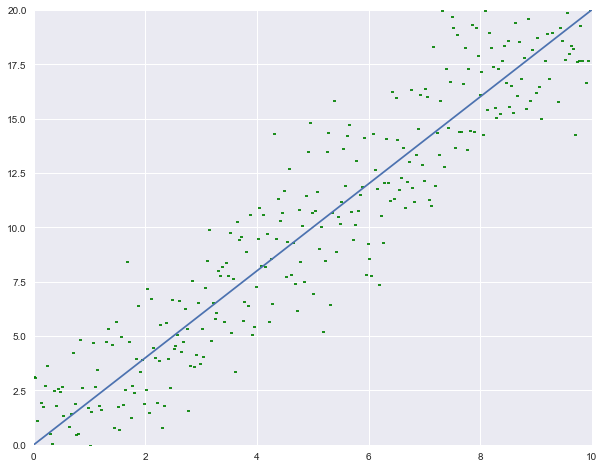

In [3]:
plt.figure(1, figsize=(10,8), )
plt.plot([0, 10], [0, 20])
plt.scatter(x, y, marker=0, s=10, c='g')
plt.axis([0, 10, 0, 20])
plt.show();

Now we 'fit' the model to the data, which means we compute the values of $\beta_0$ and $\beta_1$ that minimize the sum of the squared errors.  We use Statsmodels for fitting the model.  There are two different syntax styles to use for this.  The first one uses an X matrix and a y array, like this:

In [4]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     2149.
Date:                Mon, 20 Nov 2017   Prob (F-statistic):          2.73e-138
Time:                        09:12:41   Log-Likelihood:                -653.94
No. Observations:                 300   AIC:                             1312.
Df Residuals:                     298   BIC:                             1319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0518      0.247      0.209      0.8

We can extract any of the results from the fitted model we want, since the fitted model is a Python object and has attributes we can interrogate.

In [5]:
print('Parameters: ', results.params)

Parameters:  [ 0.05176672  1.98437476]


Statsmodels calculates 95% confidence intervals for our model coefficients, which are interpreted as follows: If the population from which this sample was drawn was **sampled 100 times**, approximately **95 of those confidence intervals** would contain the "true" coefficient.

To get the 95% confidence interval around $\beta_0$ and $\beta_1$ we can do this:

In [6]:
results.conf_int()

array([[-0.43497013,  0.53850357],
       [ 1.90013987,  2.06860965]])

## Hypothesis Testing and p-values

Closely related to confidence intervals is **hypothesis testing**. Generally speaking, you start with a **null hypothesis** and an **alternative hypothesis** (that is opposite the null). Then, you check whether the data supports **rejecting the null hypothesis** or **failing to reject the null hypothesis**.

(Note that "failing to reject" the null is not the same as "accepting" the null hypothesis. The alternative hypothesis may indeed be true, except that you just don't have enough data to show that.)

As it relates to model coefficients, here is the conventional hypothesis test:
- **null hypothesis:** There is no relationship between $x$ and $y$ (and thus $\beta_1$ equals zero)
- **alternative hypothesis:** There is a relationship between $x$ and $y$ (and thus $\beta_1$ is not equal to zero)

How do we test this hypothesis? Intuitively, we reject the null (and thus believe the alternative) if the 95% confidence interval **does not include zero**. Conversely, the **p-value** represents the probability that the coefficient is actually zero:

In [7]:
results.pvalues

array([  8.34356040e-001,   2.73305054e-138])

If the 95% confidence interval **includes zero**, the p-value for that coefficient will be **greater than 0.05**. If the 95% confidence interval **does not include zero**, the p-value will be **less than 0.05**. Thus, a p-value less than 0.05 is one way to decide whether there is likely a relationship between the feature and the response. (Again, using 0.05 as the cutoff is just a convention.)

In this case, the p-value for $x$ is far less than 0.05, and so we **believe** that there is a relationship between $x$ and $y$.

Note that we generally ignore the p-value for the intercept.

## How Well Does the Model Fit the data?

The most common way to evaluate the overall fit of a linear model is by the **R-squared** value. R-squared is the **proportion of variance explained**, meaning the proportion of variance in the observed data that is explained by the model, or the reduction in error over the **null model**. (The null model just predicts the mean of the observed response, and thus it has an intercept and no slope.)

R-squared is between 0 and 1, and higher is better because it means that more variance is explained by the model. 

In [8]:
print('R2: ', results.rsquared)

R2:  0.878232484475


We can also inspect the residuals (the errors) computed by comparing the predicted values of y to the observed ones.  The mean of the residuals should be zero and they should be normally distributed.

In [9]:
results.resid.mean()

-1.8977412234259343e-15

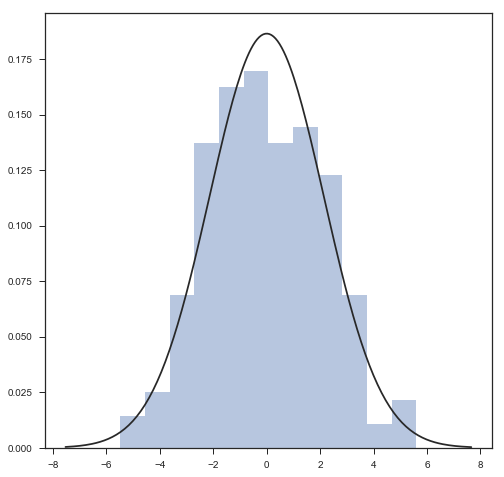

In [10]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(results.resid, fit=norm, kde=False)

## Multiple Linear Regression

Simple linear regression can easily be extended to include multiple features. This is called **multiple linear regression**:

$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n + \epsilon$

Let's add an additional x variable to our synthetic model, using x squared, and fit it again with Statsmodels.

We generate new values of $y$ using $\beta_0 = 0$, $\beta_1 = 2$ and $\beta_2 = 0.5$

In [11]:
nsample = 300
x = np.linspace(0, 10, 300)
X = np.column_stack((x, x**2))
beta = np.array([1, 2, .5])
e = np.random.normal(size=nsample)*2

In [12]:
X = sm.add_constant(X)
y = np.dot(X, beta) + e

In [13]:
X[:10]

array([[ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  0.03344482,  0.00111856],
       [ 1.        ,  0.06688963,  0.00447422],
       [ 1.        ,  0.10033445,  0.010067  ],
       [ 1.        ,  0.13377926,  0.01789689],
       [ 1.        ,  0.16722408,  0.02796389],
       [ 1.        ,  0.2006689 ,  0.04026801],
       [ 1.        ,  0.23411371,  0.05480923],
       [ 1.        ,  0.26755853,  0.07158757],
       [ 1.        ,  0.30100334,  0.09060301]])

In [14]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.605e+04
Date:                Mon, 20 Nov 2017   Prob (F-statistic):          2.56e-303
Time:                        09:13:51   Log-Likelihood:                -631.85
No. Observations:                 300   AIC:                             1270.
Df Residuals:                     297   BIC:                             1281.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3177      0.344      3.833      0.0

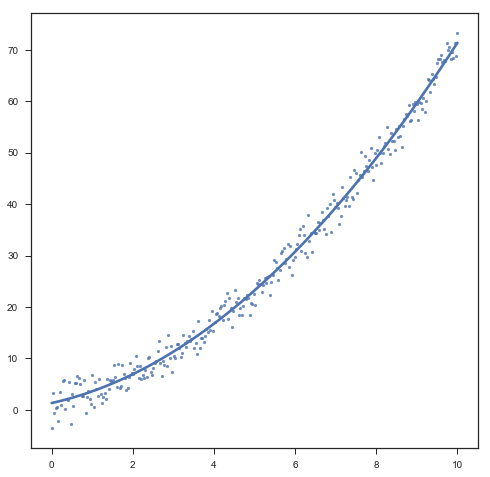

In [15]:
ax = sns.regplot(x=X[:,1], y=y, scatter_kws={"s": 10}, order=2, ci=None, truncate=True)

In [16]:
results.resid.mean()

-4.5924745487961139e-14

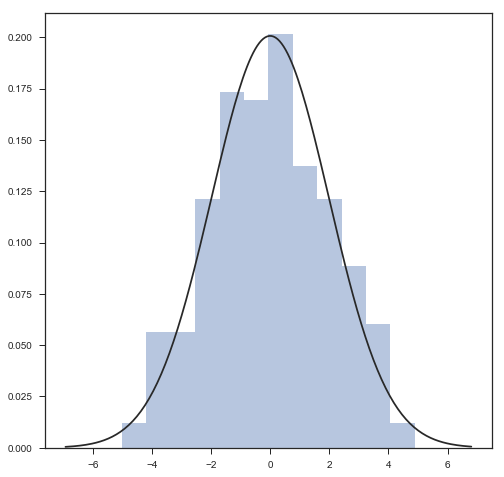

In [17]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(results.resid, fit=norm, kde=False)

**R-squared will always increase as you add more features to the model**, even if they are unrelated to the response. Thus, selecting the model with the highest R-squared is not a reliable approach for choosing the best linear model.

There is alternative to R-squared called **adjusted R-squared** that penalizes model complexity (to control for overfitting), but it generally [under-penalizes complexity](http://scott.fortmann-roe.com/docs/MeasuringError.html).

## Estimating a Multiple Regression on Housing Prices (Hedonic Regression)##

Now let's use real data.  We pull some housing sales transactions from Redfin for this, for one month of sales in San Francisco, looking back from March 5th 2017.

In [63]:
sf0 = pd.read_csv('data/redfin_2017-03-05-17-45-34-san-francisco-county-1-month.csv')
sf0.columns

Index(['SALE TYPE', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'STATE',
       'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', 'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS',
       'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME',
       'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [64]:
sf = sf0.rename(index=str, columns={'SALE TYPE': 'saletype',
    'SOLD DATE': 'solddate', 'PROPERTY TYPE': 'proptype', 'ADDRESS': 'address',
    'CITY': 'city', 'STATE': 'state', 'ZIP': 'zip', 'PRICE': 'price', 'BEDS': 'beds',
    'BATHS': 'baths', 'LOCATION': 'location', 'SQUARE FEET': 'sqft', 'LOT SIZE': 'lotsize',
    'YEAR BUILT': 'yrbuilt', 'DAYS ON MARKET': 'daysonmkt', '$/SQUARE FEET': 'pricesqft',
    'LATITUDE': 'latitude', 'LONGITUDE': 'longitude', 'HOA/MONTH': 'hoamonth',
    'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)': 'url',
    'STATUS': 'status', 'NEXT OPEN HOUSE START TIME': 'nextopenstart', 'NEXT OPEN HOUSE END TIME': 'nextopenend',
    'SOURCE': 'source', 'MLS#': 'mls', 'FAVORITE': 'favorite', 'INTERESTED': 'interested'
    })

sf.head()

,saletype,solddate,proptype,address,city,state,zip,price,beds,baths,...,status,nextopenstart,nextopenend,url,source,mls,favorite,interested,latitude,longitude
0,PAST SALE,February-7-2017,Single Family Residential,521 Cayuga Ave,San Francisco,CA,94112.0,1200000.0,2.0,1.25,...,Sold,NaN,NaN,http://www.redfin.com/CA/San-Francisco/521-Cay...,San Francisco MLS,453167,N,Y,37.728860,-122.435308
1,PAST SALE,February-10-2017,Condo/Co-op,95 Red Rock Way Unit 105M,San Francisco,CA,94131.0,590000.0,0.0,1.00,...,Sold,NaN,NaN,http://www.redfin.com/CA/San-Francisco/95-Red-...,San Francisco MLS,452726,N,Y,37.746324,-122.441517
2,PAST SALE,February-10-2017,Single Family Residential,3157 Baker St,San Francisco,CA,94123.0,3260000.0,5.0,3.50,...,Sold,NaN,NaN,http://www.redfin.com/CA/San-Francisco/3157-Ba...,San Francisco MLS,451943,N,Y,37.800218,-122.446455
3,PAST SALE,February-17-2017,Single Family Residential,2594 San Jose Ave,San Francisco,CA,94112.0,920000.0,3.0,2.00,...,Sold,NaN,NaN,http://www.redfin.com/CA/San-Francisco/2594-Sa...,MetroList,16067859,N,Y,37.716435,-122.450444
4,PAST SALE,February-27-2017,Single Family Residential,130 Brazil Ave,SAN FRANCISCO,CA,94112.0,790000.0,2.0,1.00,...,Sold,NaN,NaN,http://www.redfin.com/CA/San-Francisco/130-Bra...,MLSListings,ML81635907,N,Y,37.723920,-122.433735


In [65]:
sf.columns

Index(['saletype', 'solddate', 'proptype', 'address', 'city', 'state', 'zip',
       'price', 'beds', 'baths', 'location', 'sqft', 'lotsize', 'yrbuilt',
       'daysonmkt', 'pricesqft', 'hoamonth', 'status', 'nextopenstart',
       'nextopenend', 'url', 'source', 'mls', 'favorite', 'interested',
       'latitude', 'longitude'],
      dtype='object')

In [66]:
sf.describe()

,zip,price,beds,baths,sqft,lotsize,yrbuilt,daysonmkt,pricesqft,hoamonth,nextopenstart,nextopenend,latitude,longitude
count,308.000000,3.080000e+02,301.000000,293.000000,266.000000,139.000000,288.000000,306.00000,264.000000,159.000000,0.0,0.0,309.000000,309.000000
mean,93888.253247,1.521055e+06,2.647841,1.880546,1662.593985,3194.935252,1952.006944,14.30719,949.905303,543.874214,NaN,NaN,37.760820,-122.431289
std,2820.378426,1.063400e+06,1.862499,0.896519,1169.031917,4656.050424,39.950230,8.87308,279.135062,436.562243,NaN,NaN,0.025052,0.027834
min,59059.000000,3.500000e+03,0.000000,1.000000,300.000000,611.000000,1885.000000,2.00000,339.000000,4.000000,NaN,NaN,37.709249,-122.510730
25%,94109.000000,8.787500e+05,2.000000,1.000000,978.750000,2319.500000,1916.750000,6.00000,773.750000,342.500000,NaN,NaN,37.739065,-122.443876
50%,94114.000000,1.271000e+06,2.000000,2.000000,1360.000000,2513.000000,1941.000000,12.00000,963.500000,473.000000,NaN,NaN,37.762549,-122.428527
75%,94122.000000,1.813750e+06,3.000000,2.000000,1904.750000,3090.000000,1996.000000,23.00000,1106.000000,683.000000,NaN,NaN,37.781520,-122.412238
max,94158.000000,1.025000e+07,18.000000,5.500000,9504.000000,56024.000000,2017.000000,30.00000,2053.000000,4413.000000,NaN,NaN,37.805816,-122.371007


Let's get some additional census data to merge on to our sales transactions.  But we don't have a census block on our records.... what to do?  We can go to our trusty FCC geocoder API, of course!

**In the interest of time (it takes a couple of minutes to run), you can skip the next three cells and just start from the cell that loads the data from a csv 4 cells below.**

In [71]:
# pass the FCC API lat/long and get FIPS data back - return block fips and county name
def get_fips(row):
    time.sleep(pause)
    url = 'http://data.fcc.gov/api/block/find?format=json&latitude={}&longitude={}'
    request = url.format(row['latitude'], row['longitude'])
    response = requests.get(request)
    data = response.json()
    
    # return multiple values as a series - this will create a dataframe with multiple columns
    return pd.Series({'fips_code':data['Block']['FIPS'], 'county':data['County']['name']})

In [72]:
%%time
pause = 0.1
fips = sf.apply(get_fips, axis=1)
sf = pd.concat([sf, fips], axis=1)
sf1.head()

CPU times: user 823 ms, sys: 105 ms, total: 929 ms
Wall time: 2min 2s


In [59]:
sf.to_csv('data/sf1_blk.csv')

**Start from here if you want to skip the geocoding step...**

In [128]:
sf = pd.read_csv('data/sf1_blk.csv', usecols=['proptype', 'price', 'beds', 'baths', 'sqft', 'lotsize',\
    'yrbuilt', 'hoamonth', 'fips_code', 'latitude', 'longitude'], converters={'fips_code': str})
sf.head()

,proptype,price,beds,baths,sqft,lotsize,yrbuilt,hoamonth,latitude,longitude,fips_code
0,Single Family Residential,1200000.0,2.0,1.25,1500.0,2265.0,1940.0,NaN,37.728860,-122.435308,060750255003002
1,Condo/Co-op,590000.0,0.0,1.00,650.0,NaN,1972.0,443.0,37.746324,-122.441517,060750216002010
2,Single Family Residential,3260000.0,5.0,3.50,3646.0,2050.0,2003.0,NaN,37.800218,-122.446455,060750127003003
3,Single Family Residential,920000.0,3.0,2.00,1287.0,2495.0,1960.0,NaN,37.716435,-122.450444,060750312022019
4,Single Family Residential,790000.0,2.0,1.00,1125.0,2495.0,1923.0,NaN,37.723920,-122.433735,060750260012001


In [129]:
sv = pd.read_csv('data/smallvars.csv', converters={'block_id': str})
sv.head()

,Unnamed: 0,block_id,bgpop,bgacres,bgjobs,bgmedkids,bgmedhhs,bgmedinc,proprent,lowinc1500m,...,lnret3000m,lnfire3000m,lnserv3000m,prop1per,prop2per,bgmedagehd,puma1,puma2,puma3,puma4
0,0,060014271001000,888.0,90.106156,465.0,0.0,2.0,80000.0,0.558603,5.991451,...,7.457814,5.329694,8.082779,0.34414,0.381546,57.0,0,0,0,0
1,1,060014271001001,888.0,90.106156,465.0,0.0,2.0,80000.0,0.558603,5.991451,...,7.457814,5.329694,8.082779,0.34414,0.381546,57.0,0,0,0,0
2,2,060014271001002,888.0,90.106156,465.0,0.0,2.0,80000.0,0.558603,5.991451,...,7.457814,5.329694,8.082779,0.34414,0.381546,57.0,0,0,0,0
3,3,060014271001003,888.0,90.106156,465.0,0.0,2.0,80000.0,0.558603,6.231131,...,7.558539,5.431654,8.188618,0.34414,0.381546,57.0,0,0,0,0
4,4,060014271001004,888.0,90.106156,465.0,0.0,2.0,80000.0,0.558603,6.107350,...,7.690577,5.521359,8.287781,0.34414,0.381546,57.0,0,0,0,0


In [130]:
sf1 = pd.merge(sf, sv, left_on='fips_code', right_on='block_id', how='inner')
sf1.columns

Index(['proptype', 'price', 'beds', 'baths', 'sqft', 'lotsize', 'yrbuilt',
       'hoamonth', 'latitude', 'longitude', 'fips_code', 'Unnamed: 0',
       'block_id', 'bgpop', 'bgacres', 'bgjobs', 'bgmedkids', 'bgmedhhs',
       'bgmedinc', 'proprent', 'lowinc1500m', 'highinc1500m', 'lnjobs5000m',
       'lnjobs30km', 'lnpop400m', 'lnpop800m', 'lnjobs800m', 'propwhite',
       'propblack', 'pumahhden', 'lnbasic3000m', 'lntcpuw3000m', 'pumajobden',
       'lnjobs40km', 'lnret3000m', 'lnfire3000m', 'lnserv3000m', 'prop1per',
       'prop2per', 'bgmedagehd', 'puma1', 'puma2', 'puma3', 'puma4'],
      dtype='object')

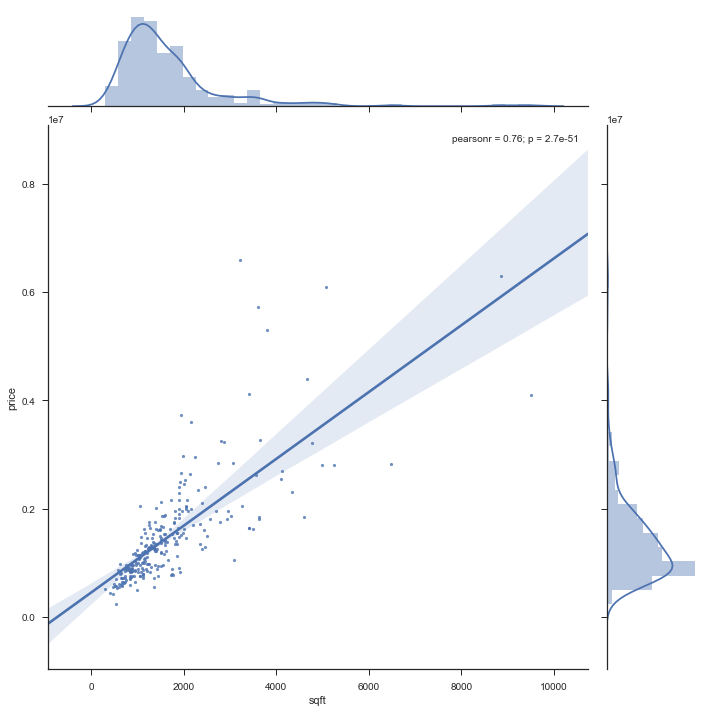

In [98]:
g = sns.jointplot("sqft", "price", data=sf1, kind="reg", scatter_kws={"s": 10}, size=10)

Let's fit a simple linear regression of price on sqft, since there is clearly a strong relationship between them.

We will use Statsmodels for this as before, but now we use the Patsy syntax to specify the model.  Patsy uses the same format as the R language for specifying models.  The link below provides good documentation on the format.

http://www.statsmodels.org/dev/example_formulas.html

In [99]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('price ~ sqft', 
                 data=sf1, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     361.3
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           2.74e-51
Time:                        10:20:59   Log-Likelihood:                -3907.9
No. Observations:                 265   AIC:                             7820.
Df Residuals:                     263   BIC:                             7827.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.52e+05    6.6e+04      6.847      0.0

How would you intepret the R-squared value?

How can you interpret the coefficient on sqft?

A common thing to explore is whether a transformation of the dependent and/or independent variables help improve the degree to which the relationship is linear, and the fit of the model.  Most models of housing prices, or 'hedonic price models' are specified with the log of price, and often the log of continuous variables like sqft.  Let's look at the relationship once we log-transform both:

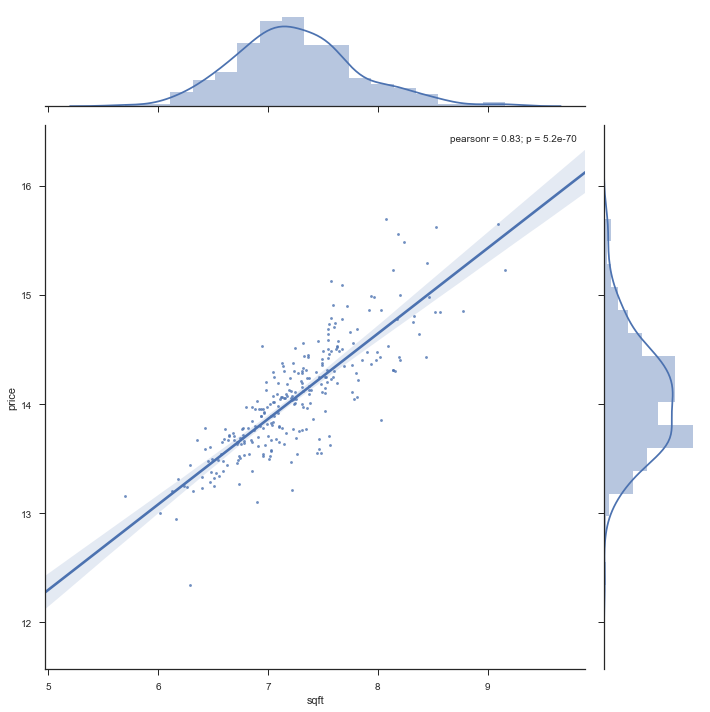

In [100]:
g = sns.jointplot(np.log(sf1['sqft']), np.log(sf1['price']), kind="reg", scatter_kws={"s": 8}, size=10)

And now let's re-estimate the model using the log-log transformation of price and sqft.

In [101]:
y, X = dmatrices('np.log(price) ~ np.log(sqft)', 
                 data=sf1, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     603.0
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           5.17e-70
Time:                        10:21:06   Log-Likelihood:                -44.561
No. Observations:                 265   AIC:                             93.12
Df Residuals:                     263   BIC:                             100.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.3799      0.232     36.115   

The model fit improves considerably.  How do you interpret the coefficient for sqft now?

Next let's add the number of baths and see how that changes the model.

In [102]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths', 
                 data=sf1, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     301.5
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           1.43e-67
Time:                        10:21:09   Log-Likelihood:                -32.226
No. Observations:                 255   AIC:                             70.45
Df Residuals:                     252   BIC:                             81.08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.8761      0.339     26.221   

Let's add bedrooms now and see how that changes the model...

In [103]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + beds', 
                 data=sf1, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     236.4
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           8.26e-73
Time:                        10:21:12   Log-Likelihood:                -16.926
No. Observations:                 255   AIC:                             41.85
Df Residuals:                     251   BIC:                             56.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.5064      0.401     18.727   

Hmm.  Expected that result on bedrooms?

In [104]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + beds + np.log(lotsize)', 
                 data=sf1, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     55.18
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           2.36e-25
Time:                        10:21:15   Log-Likelihood:                -12.443
No. Observations:                 114   AIC:                             34.89
Df Residuals:                     109   BIC:                             48.57
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7696      0.774     

Hmm... the R-Squared went down when we added a variable?  That's strange.  What happened?

In [105]:
sf1.proptype.value_counts()

Condo/Co-op                  157
Single Family Residential    113
Multi-Family (2-4 Unit)       24
Multi-Family (5+ Unit)         7
Townhouse                      5
Vacant Land                    3
Name: proptype, dtype: int64

In [131]:
single = sf1[sf1['proptype']=='Single Family Residential'] 

In [132]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + beds + np.log(lotsize) ', 
                 data=single, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     55.07
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           2.76e-23
Time:                        10:37:30   Log-Likelihood:                -2.4557
No. Observations:                  94   AIC:                             14.91
Df Residuals:                      89   BIC:                             27.63
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.0077      0.893     

In [133]:
condo = sf1[sf1['proptype']=='Condo/Co-op'] 

In [109]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + beds ', 
                 data=condo, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     169.9
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           3.88e-45
Time:                        10:21:26   Log-Likelihood:                 4.7538
No. Observations:                 136   AIC:                            -1.508
Df Residuals:                     132   BIC:                             10.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.1881      0.590     13.874   

**Adding dummy variables**

In [173]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + C(beds)  ', 
                 data=condo, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     85.31
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           1.75e-42
Time:                        12:22:58   Log-Likelihood:                 6.2280
No. Observations:                 136   AIC:                             1.544
Df Residuals:                     129   BIC:                             21.93
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.3632      0.601     13.

**Adding Interaction Terms**

In [174]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + beds + beds * baths ', 
                 data=condo, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     130.1
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           1.28e-44
Time:                        12:24:17   Log-Likelihood:                 6.2766
No. Observations:                 136   AIC:                            -2.553
Df Residuals:                     131   BIC:                             12.01
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.2417      0.587     14.049   

**Adding neighborhood variables**

In [114]:
y, X = dmatrices('np.log(price) ~ np.log(sqft) + baths + beds  + bgmedinc +\
                 proprent + lnjobs5000m', 
                 data=condo, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     103.7
Date:                Mon, 20 Nov 2017   Prob (F-statistic):           6.56e-47
Time:                        10:22:56   Log-Likelihood:                 17.048
No. Observations:                 136   AIC:                            -20.10
Df Residuals:                     129   BIC:                            0.2933
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.6014      0.591     12.853   

In [110]:
data = observed.join(predicted.to_frame(name='predicted'))
data.head()

,np.log(price),predicted
1,13.287878,13.383929
2,12.948010,13.137415
3,13.458836,13.601071
7,14.058457,14.125005
8,14.690979,14.506663


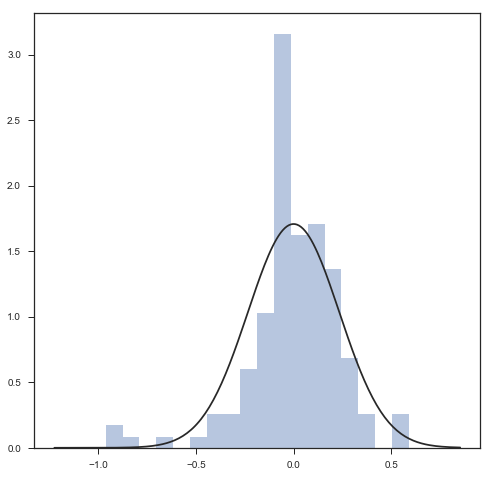

In [111]:
plt.rcParams['figure.figsize']=8,8

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(residuals, fit=norm, kde=False)


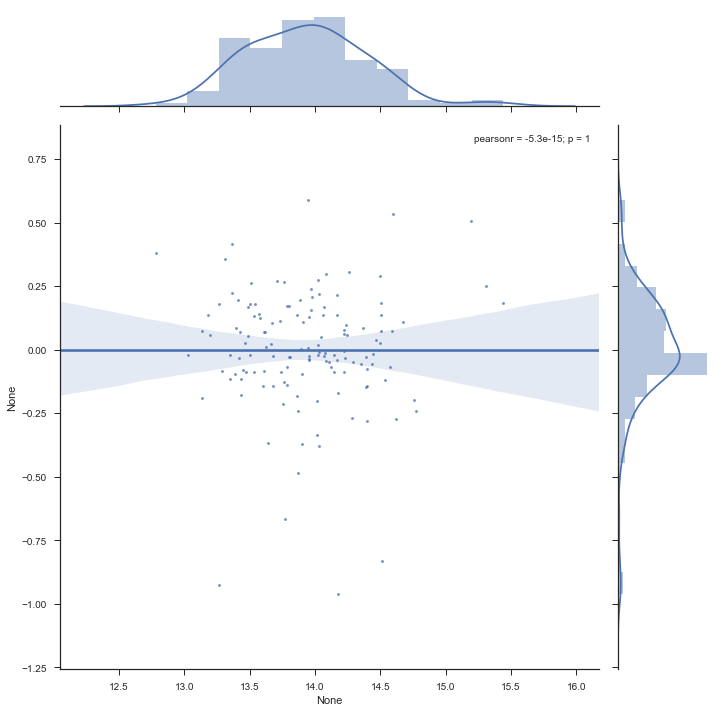

In [112]:
g = sns.jointplot(predicted, residuals, kind="reg", scatter_kws={"s": 8}, size=10)

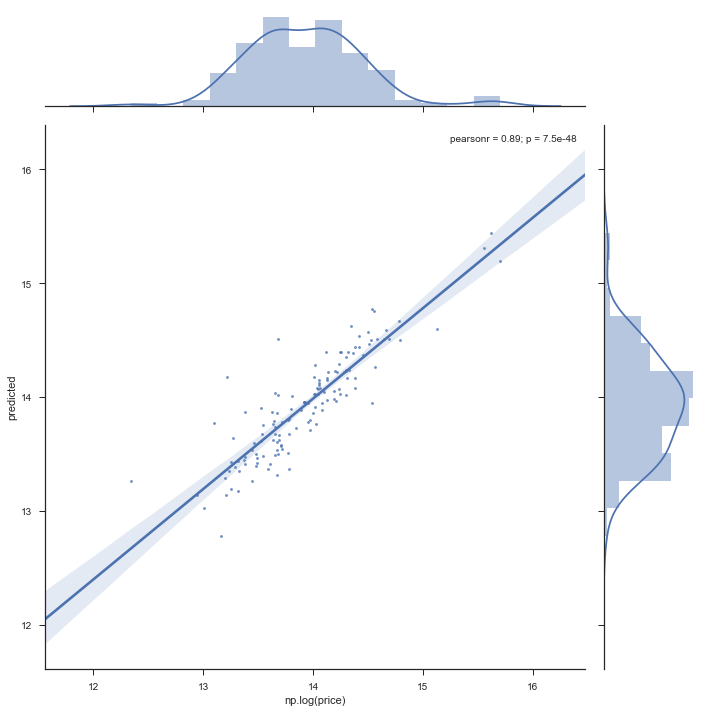

In [113]:
g = sns.jointplot("np.log(price)", "predicted", data=data, kind="reg", scatter_kws={"s": 8}, size=10)

If you want to explore your data further to look at pairwise relationships, you can use the Seaborn PairGrid plot.

In [118]:
keepcols = [ 'price', 'beds', 'baths', 'sqft', 'lotsize', 'yrbuilt']
condo_small=condo[keepcols]
condo_small.head()

,price,beds,baths,sqft,lotsize,yrbuilt
1,590000.0,0.0,1.0,650.0,NaN,1972.0
2,420000.0,0.0,1.0,474.0,NaN,1972.0
3,700000.0,1.0,1.0,830.0,NaN,1972.0
7,1275000.0,3.0,2.0,1270.0,NaN,1906.0
8,2400000.0,3.0,2.5,1894.0,NaN,NaN


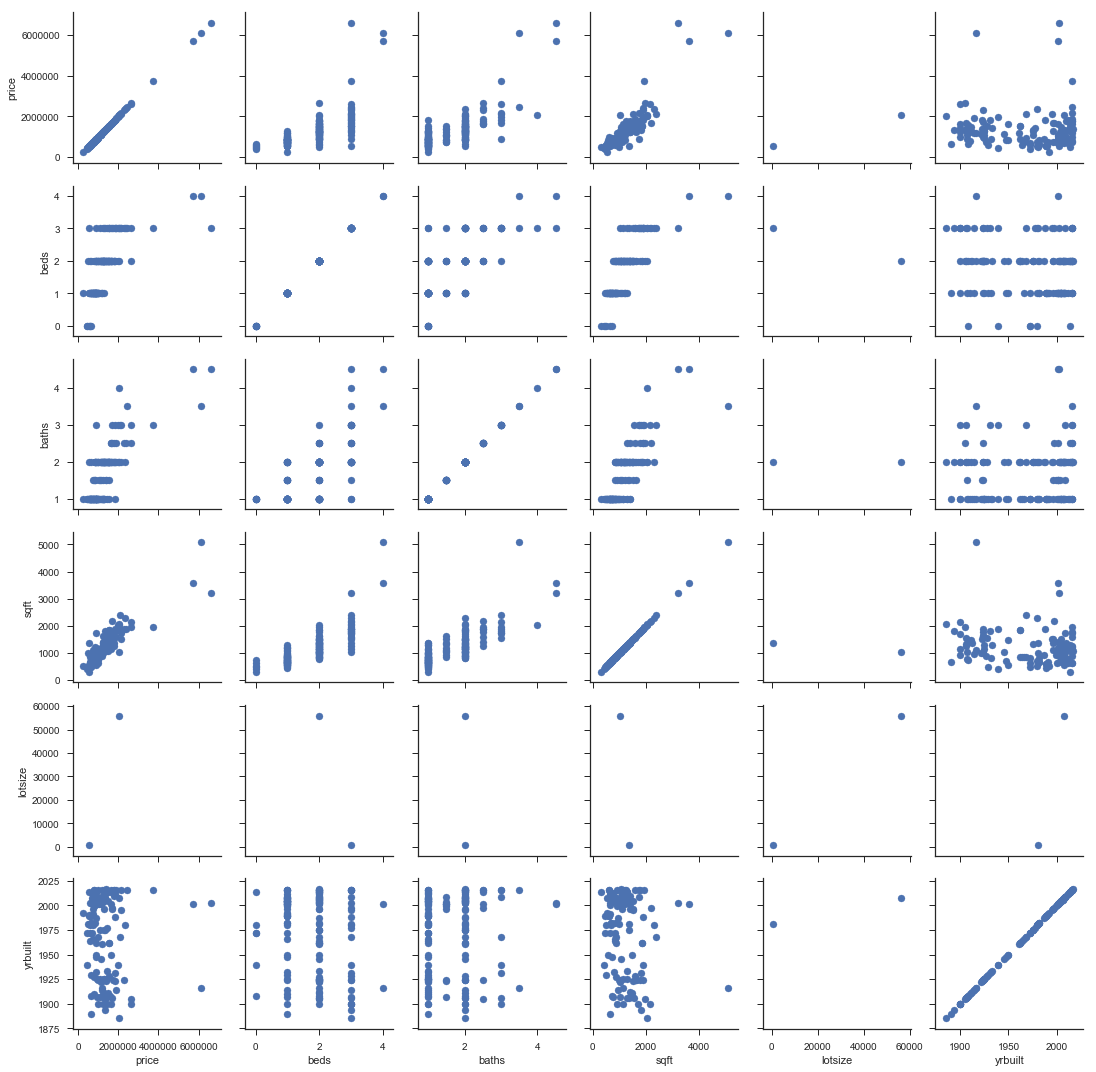

In [119]:
g = sns.PairGrid(condo_small)
g.map(plt.scatter);


Now let's map our data to examine where these sales occurred and to explore locational factors.

In [172]:
sanfrancisco=[37.7739, -122.4312]

map_1 = folium.Map(location=sanfrancisco, zoom_start=12, max_zoom=16, min_zoom=13, tiles='Cartodb Positron')
for index, row in condo.iterrows():
    folium.Marker([row['latitude'], row['longitude']],popup= '$'+str(row['price'])).add_to(map_1)

map_1